# Fall 2022 CE170A HW2: Sensor Data Analysis
v4 - Fall 2023: Prof. Kenichi Soga, Connor Geudeker

v3 - Fall 2022: Prof. Kenichi Soga, Jaewon Saw, Shih-Hung Chiu

v2 - Fall 2021: Prof. Kenichi Soga, Renjie Wu, Yaobin Yang, James Wang

In [8]:
import os
!wget "https://github.com/UCB-CE170a/Fall2023/raw/main/Homework/Homework2/ProcessedData.zip" -O ProcessedData.zip
!unzip ProcessedData

--2023-09-13 10:59:37--  https://github.com/UCB-CE170a/Fall2023/raw/main/Homework/Homework2/ProcessedData.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UCB-CE170a/Fall2023/main/Homework/Homework2/ProcessedData.zip [following]
--2023-09-13 10:59:37--  https://raw.githubusercontent.com/UCB-CE170a/Fall2023/main/Homework/Homework2/ProcessedData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38154736 (36M) [application/zip]
Saving to: ‘ProcessedData.zip’

ProcessedData.zip   100%[===================>]  36.39M  --.-KB/s    in 0.1s    

2023-09-13 10:59:38 (271 MB/s) - ‘ProcessedData.zip

## Background

There are two ways to understand phenomena scientifically. One is through mathematical modeling and computer simulation, which is the purpose of our quiz 2 (truss finite element simulation). The other is through experiments, which are performed in this class (model bridge loading experiment). By comparing experimental results with simulation results, one may appreciate the complexity of real-world phenomena and have a deeper understanding of the power and limitations of the simulation method.




<center>
<img src="https://github.com/UCB-CE170a/Fall2020/raw/master/homeworks/hw5/figures/overview.png" alt="Node numbering" width="600" />
    
    Figure 1. Simulation Vs. Experiment
</center>

In this assignment, you are going to analyze the sensor data from the model bridge experiment and compare the result with the truss simulation performed in Quiz 2. The data you are going to explore are as follows:
* Displacement data from displacement sensors (potentiometric measuring devices),
* Tilt data from WSN tilt motes, and
* Distributed (spatial) strain data from fiber optics sensors.


The typical workflow of data analysis is summarized in Figure 2.
<center>
<img src="https://github.com/UCB-CE170a/Fall2020/raw/master/homeworks/hw5/figures/data_processing.png" alt="Node numbering" width="600" />
    
    Figure 2. Typical workflow of data analysis
</center>

We start with the raw data collected from the sensor systems. Then, we preprocess the raw data and store the cleaned data into a data storage system. There are various reasons for data preprocessing. Missing data handling, experiment/equipment setting adjustment, and data format conversion are common reasons (there are more, of course).

Most data can be represented as a single spreadsheet. Such data include the displacement data and tilt data that we are going to explore in this assignment. However, in some cases, data can have complex structures; such as the distributed strain data we have in this case. The distributed strain data is collected from fiber optics sensors, which record the strain along with the fiber (spatial component) during the experiment (time component). As you all know, we deployed numerous fiber optics sensors (with different lengths) across different structure members to monitor the load responses of the model bridge. Since we have three model bridges this year, each with different sensor deployment strategies, the sensors' raw data are huge and hard to handle. For the ease of this exercise, the distributed strain data is preprocessed by us, and only some cleaned data from certain bridge members are presented here.


Having the cleaned data on our hands, we can perform various postprocessing techniques such as statistical analysis, and most importantly, visualize the data for interpretation.

The data are given in a format that follows the numbering given in the following figures.

Figure 3 shows the nodal numbering of the model bridge.
<center>
<img src="https://github.com/UCB-CE170a/Fall2020/raw/master/homeworks/hw5/figures/bridge_diagram.png" alt="Node numbering" width="500" />
    
    Figure 3. Node numbering for the model bridge
</center>


## Videos from bridge tests
Refer to the videos <a href="https://drive.google.com/drive/folders/1HdlADyA2HnBFveScQDFVCDR5zo17PDfv?usp=sharing">here</a>
 to look back on any details you need for the following sections.

# Data Exploration

We tested three bridges: (1) Single-angle bridge, (2) Double-angle bridge, (3) Double-angle bridge with defect. Throughout this assignment, we will use the indices 1, 2, and 3 to refer to those bridges.

Let's first install the required libraries and then read the processed data for the three bridges (in desired units and format) that we'll need for our analysis.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

The following cell block simply sets up an interactive function that will allow us to quickly look at and sift through the data. You can select multiple tests, a sensor of interest, and multiple datapoints of interest. From there you can plot and assign this data to the variable. While the function call below is to let you see how the function works, please do not edit the other function calls as they are directed to help you complete the assignment.

In [142]:
test_widget = widgets.SelectMultiple(options=['Test1', 'Test2', 'Test3'])
sensor_widget = widgets.Dropdown()
data_widget = widgets.SelectMultiple()
xValue = widgets.Dropdown(options = ["Time [s]","Load [kN]"],value = "Time [s]")

def getFileNames(filePath):
  filenames=[]
  for filename in os.listdir(filePath):
    f = os.path.join(filePath, filename)
    filenames.append(f)
  return filenames

def update_sensors(*args):
  sourceFolder = '/content/ProcessedData/'
  try:
    newFolders = getFileNames(sourceFolder+test_widget.value+'/')
  except:
    newFolders = getFileNames(sourceFolder+'Test1/')
  options = [folder.split('/')[-1] for folder in newFolders]
  sensor_widget.options = options
test_widget.observe(update_sensors)

def update_data(*args):
  sourceFolder = '/content/ProcessedData/'
  try:
    newFolders = getFileNames(sourceFolder+test_widget.value[0]+'/'+sensor_widget.value+'/')
  except:
    newFolders = getFileNames(sourceFolder+'Test1/FiberOpticData/')
  options = [folder.split('/')[-1] for folder in newFolders]
  data_widget.options = options
sensor_widget.observe(update_data)

plot = Checkbox(False, description='Ready to plot data?')
peak = Checkbox(False, description="Cutoff at peak?")

def uncheckBox(*args):
  plot.value = False
test_widget.observe(uncheckBox)
sensor_widget.observe(uncheckBox)
data_widget.observe(uncheckBox)

def plottingData(test,sensor,data,xAxisData,plotData,peakEnd):
  global dataDFs
  filePath = '/content/ProcessedData/'
  tests = list(test_widget.value)
  datas = list(data_widget.value)
  if (not tests) | (not datas):
    plotData = False
    print("Not enough information selected yet.")
  else:
    print("Enough information has been selected.")
  if plotData:
    legendItems = []
    dataDFs = []
    fig = plt.figure()
    ax = fig.gca()
    for test in tests:
      xAxisFilePath = filePath + test +'/LoadData/ActuatorLoad [kN].csv'
      xDF = pd.read_csv(xAxisFilePath,delimiter=',',index_col=False)
      if peak.value:
        endTime = np.array([124.480671,87.656807,50.032424])[np.array(test_widget.options)==test][0]
      else:
        endTime = xDF.iloc[-1,1]
      xDF = xDF[xDF.iloc[:,1]<=endTime]
      if xValue.value == "Time [s]":
        xData = xDF.iloc[:,1]
      else:
        xData = xDF.iloc[:,-1]
      for data in datas:
        testFilePath = filePath + test +'/'+sensor_widget.value+'/'+data
        dataDF = pd.read_csv(testFilePath,delimiter=',',index_col=False)
        dataDF = dataDF.drop(columns = [dataDF.columns.to_list()[0]])
        dataDF = dataDF[dataDF.iloc[:,0]<=endTime]
        dataDF.iloc[:,0] = xData
        dataDF.rename(columns={ dataDF.columns[0]: xValue.value }, inplace = True)
        dataDFs.append(dataDF)
        plt.plot(xData,dataDF.iloc[:,-1])
        legendItems.append(test+data)
    plt.xlabel(xValue.value)
    plt.ylabel(dataDF.columns.to_list()[-1])
    ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
    ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
    ax.set_title('Data vs. Time', fontsize = 14)
    plt.legend(legendItems)
    plt.show()
  else:
    print("Change the options and then check the box to load the graph.")

testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', options=('Test1', 'Test2', 'Test3'), value=()), Dropd…

# (1) Loading processes
Let's take a look at the loading processes first.

In [115]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LoadData'
data_widget.value = ('ActuatorLoad [kN].csv',)
xValue.value = "Time [s]"
plot.value = True
peak.value = False

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

In [116]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LoadData'
data_widget.value = ('ActuatorDisplacement [m].csv',)
xValue.value = "Time [s]"
plot.value = True
peak.value = False

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

<font color='red'>Question: </font> For each bridge, what were the maximum load and the corresponding number of time steps taken to reach the maximum load? Does the above plot match your on-site observations? Is the plot as you would expect?

<font color='red'>Answer: </font>

# (2) Expansion of bottom members

Now let's take a look at how the bottom members responded to the load. To see the expansion of those members, we will need data from the linear variable differential transformers (LVDTs) that we placed at each end of the bottom members. As seen from Figures 3 and 4, we see that we need LVDTs 2 and 7 for member AB and LVDTs 3 and 6 for member DC.
<center>
<img src="https://github.com/UCB-CE170a/Fall2021/raw/master/Homeworks/HW2/images/lvdt_position.jpg" alt="Node numbering" width="800" />
    
    Figure 4.1 LVDT configuration for the experiment.
</center>

<center>
<img src="https://github.com/UCB-CE170a/Fall2021/raw/master/Homeworks/HW2/images/figure4.png" alt="A bridge." width="600" />
    
    Figure 4.2 Dimensions of the model
</center>

## (2.1) Member AE

Lets first load and plot the data collected for the LVDT's on either side of member AE: LVDT3 and LVDT7

In [117]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LVDTData'
data_widget.value = ('LVDT3 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

In [118]:
# Call information
LVDT3DFs = dataDFs

In [119]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LVDTData'
data_widget.value = ('LVDT7 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

In [120]:
# Call information
LVDT7DFs = dataDFs

Now, we use the LVDT 2 and LVDT 7 data to plot the expansion of member AB:

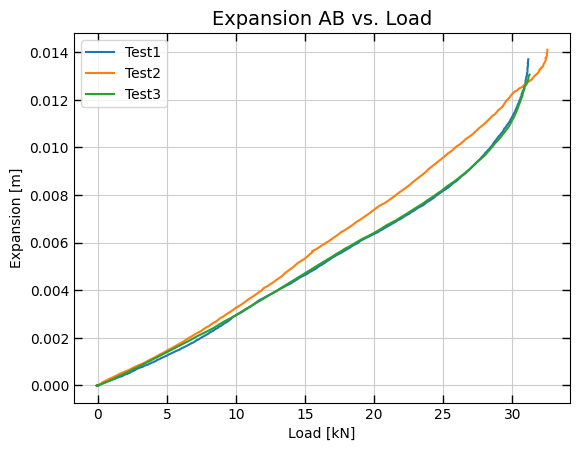

In [121]:
fig = plt.figure()
ax = fig.gca()
for i in [0,1,2]:
  expansion = LVDT3DFs[i].iloc[:,-1].to_numpy()+LVDT7DFs[i].iloc[:,-1].to_numpy()
  plt.plot(LVDT3DFs[i].iloc[:,0],expansion)
plt.xlabel("Load [kN]")
plt.ylabel("Expansion [m]")
ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
ax.set_title('Expansion AB vs. Load', fontsize = 14)
plt.legend(["Test1","Test2","Test3"])
plt.show()

<font color='red'>Question: </font> For each of the three bridges, describe the behavior of the LVDTs and the behavior of the bottom member using the plotted figures above. Given these displacements, what strains would you expect in the bottom members? How do the experimental results compare to your Quiz 2 calculations?

<font color='red'>Answer:</font>

## (2.2) Member DC
We repeat the process for member GL with LVDTs 2 and 6:

In [123]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LVDTData'
data_widget.value = ('LVDT2 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

In [124]:
# Call information
LVDT2DFs = dataDFs

In [125]:
# Load appropriate information
test_widget.value = ('Test1', 'Test2', 'Test3')
sensor_widget.value = 'LVDTData'
data_widget.value = ('LVDT6 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0, 1, 2), options=('Test1', 'Test2', 'Test3'),…

In [126]:
# Call information
LVDT6DFs = dataDFs

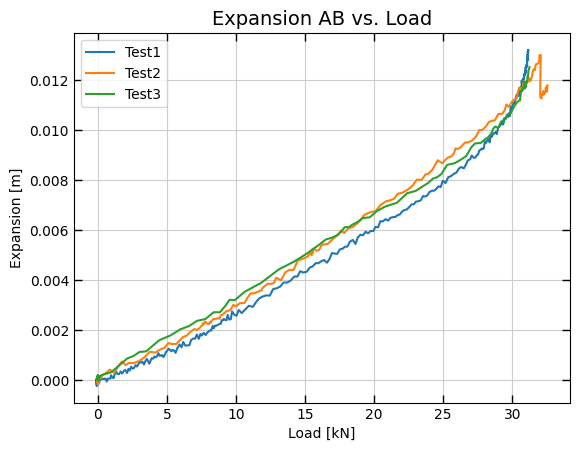

In [127]:
fig = plt.figure()
ax = fig.gca()
for i in [0,1,2]:
  expansion = LVDT2DFs[i].iloc[:,-1].to_numpy()+LVDT6DFs[i].iloc[:,-1].to_numpy()
  plt.plot(LVDT2DFs[i].iloc[:,0],expansion)
plt.xlabel("Load [kN]")
plt.ylabel("Expansion [m]")
ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
ax.set_title('Expansion AB vs. Load', fontsize = 14)
plt.legend(["Test1","Test2","Test3"])
plt.show()

<font color='red'>Question: </font> How does the behavior of Member DC compare to that of Member AB? What do you expect and what is the actual behavior?

<font color='red'>Answer: </font>

# (3) Rotation at the top of the bridge

Let's explore the tiltmeter data. Figure 5 shows the location of the WSN tilt motes and the orientation of the two orthogonal axes. The direction of angle is given for both longitudinal direction (L) and transverse direction (T).

We will focus making a comparison between bridge 1 (single-angle) and bridge 2 (double-angle) for this section.

<center>
<img src="https://github.com/UCB-CE170a/Fall2021/raw/master/Homeworks/HW2/images/tilt_defination.jpg" alt="Node numbering" width="600" />
    
    Figure 5. The locations of WSN tilt motes.
</center>

In [143]:
# Load appropriate information
test_widget.value = ('Test1',)
sensor_widget.value = 'TiltData'
data_widget.value = ('Back.csv','Front.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0,), options=('Test1', 'Test2', 'Test3'), valu…

In [144]:
# Load appropriate information
test_widget.value = ('Test2',)
sensor_widget.value = 'TiltData'
data_widget.value = ('Back.csv','Front.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(1,), options=('Test1', 'Test2', 'Test3'), valu…

In [145]:
# Load appropriate information
test_widget.value = ('Test3',)
sensor_widget.value = 'TiltData'
data_widget.value = ('Back.csv','Front.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

<font color='red'>Question: </font> Using the two rotation plots above, discuss how the two bridges behaved as they were about to fail. Do the failure patterns match the your observations?

<font color='red'>Answer: </font>

<font color='red'>Question: </font> Think about what role tiltmeters could play in providing early warning of model bridge failure.

<font color='red'>Answer: </font>

We can also calculate a "global" tilt of the entire top plate by looking at the results of the wire potentiometers. The following plots the original data and processes it to derive this "global" tilt.

In [206]:
# Load appropriate information
test_widget.value = ('Test1',)
sensor_widget.value = 'WirePotData'
data_widget.value = ('WirePot1 [m].csv', 'WirePot2 [m].csv', 'WirePot3 [m].csv', 'WirePot4 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0,), options=('Test1', 'Test2', 'Test3'), valu…

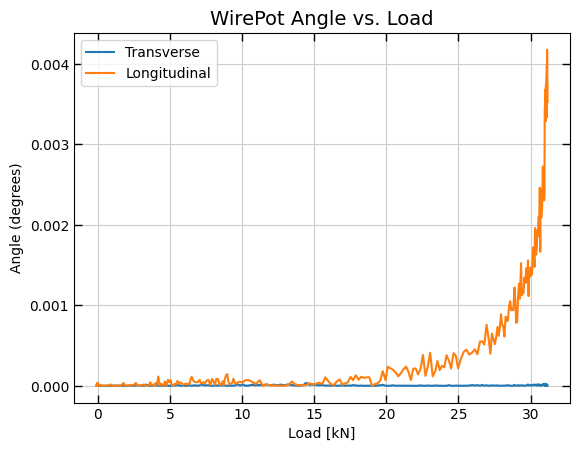

In [220]:
T1WPData = dataDFs
dT = 0.25
dL = 0.10
angleTs = []
angleLs = []
for i in range(0,len(T1WPData[0])):
  wp1 = np.array([0,0,T1WPData[0].iloc[i,1]])
  wp2 = np.array([0,dT,T1WPData[1].iloc[i,1]])
  wp3 = np.array([dL,dT,T1WPData[2].iloc[i,1]])
  wp4 = np.array([dL,0,T1WPData[3].iloc[i,1]])
  a1,b1,c1 = np.cross(wp3-wp1,wp2-wp1)
  a2,b2,c2 = np.cross(wp4-wp1,wp3-wp1)
  a3,b3,c3 = np.cross(wp4-wp2,wp3-wp2)
  a4,b4,c4 = np.cross(wp4-wp1,wp2-wp1)
  normal = np.array([np.mean([a1,a2,a3,a4]),np.mean([b1,b2,b3,b4]),np.mean([c1,c2,c3,c4])])
  normalT = normal*np.array([0,1,1])
  normalL = normal*np.array([1,0,1])
  angleT= (180/np.pi)*np.cos(np.dot(normalT,np.array([0,0,1]))/np.linalg.norm(normalT))
  angleL= (180/np.pi)*np.cos(np.dot(normalL,np.array([0,0,1]))/np.linalg.norm(normalL))
  angleTs.append(angleT)
  angleLs.append(angleL)

angleTs = angleTs - angleTs[0]
angleLs = angleLs - angleLs[0]
fig = plt.figure()
ax = fig.gca()
plt.plot(T1WPData[0].iloc[:,0],angleTs)
plt.plot(T1WPData[0].iloc[:,0],angleLs)
plt.xlabel("Load [kN]")
plt.ylabel("Angle (degrees)")
ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
ax.set_title('WirePot Angle vs. Load', fontsize = 14)
plt.legend(["Transverse","Longitudinal"])
plt.show()

In [221]:
# Load appropriate information
test_widget.value = ('Test2',)
sensor_widget.value = 'WirePotData'
data_widget.value = ('WirePot1 [m].csv', 'WirePot2 [m].csv', 'WirePot3 [m].csv', 'WirePot4 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(1,), options=('Test1', 'Test2', 'Test3'), valu…

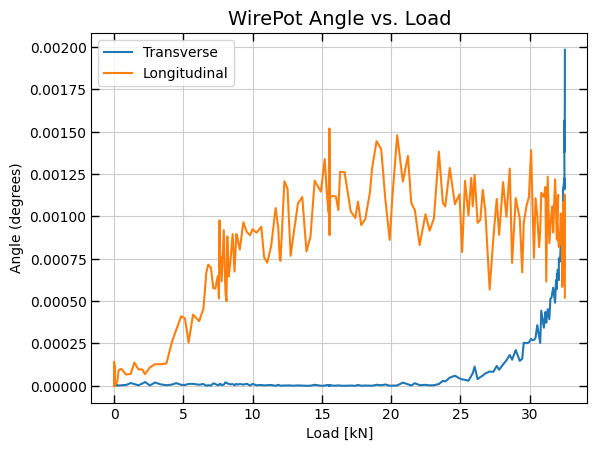

In [222]:
T1WPData = dataDFs
dT = 0.25
dL = 0.10
angleTs = []
angleLs = []
for i in range(0,len(T1WPData[0])):
  wp1 = np.array([0,0,T1WPData[0].iloc[i,1]])
  wp2 = np.array([0,dT,T1WPData[1].iloc[i,1]])
  wp3 = np.array([dL,dT,T1WPData[2].iloc[i,1]])
  wp4 = np.array([dL,0,T1WPData[3].iloc[i,1]])
  a1,b1,c1 = np.cross(wp3-wp1,wp2-wp1)
  a2,b2,c2 = np.cross(wp4-wp1,wp3-wp1)
  a3,b3,c3 = np.cross(wp4-wp2,wp3-wp2)
  a4,b4,c4 = np.cross(wp4-wp1,wp2-wp1)
  normal = np.array([np.mean([a1,a2,a3,a4]),np.mean([b1,b2,b3,b4]),np.mean([c1,c2,c3,c4])])
  normalT = normal*np.array([0,1,1])
  normalL = normal*np.array([1,0,1])
  angleT= (180/np.pi)*np.cos(np.dot(normalT,np.array([0,0,1]))/np.linalg.norm(normalT))
  angleL= (180/np.pi)*np.cos(np.dot(normalL,np.array([0,0,1]))/np.linalg.norm(normalL))
  angleTs.append(angleT)
  angleLs.append(angleL)

angleTs = angleTs - angleTs[0]
angleLs = angleLs - angleLs[0]
fig = plt.figure()
ax = fig.gca()
plt.plot(T1WPData[0].iloc[:,0],angleTs)
plt.plot(T1WPData[0].iloc[:,0],angleLs)
plt.xlabel("Load [kN]")
plt.ylabel("Angle (degrees)")
ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
ax.set_title('WirePot Angle vs. Load', fontsize = 14)
plt.legend(["Transverse","Longitudinal"])
plt.show()

In [223]:
# Load appropriate information
test_widget.value = ('Test3',)
sensor_widget.value = 'WirePotData'
data_widget.value = ('WirePot1 [m].csv', 'WirePot2 [m].csv', 'WirePot3 [m].csv', 'WirePot4 [m].csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

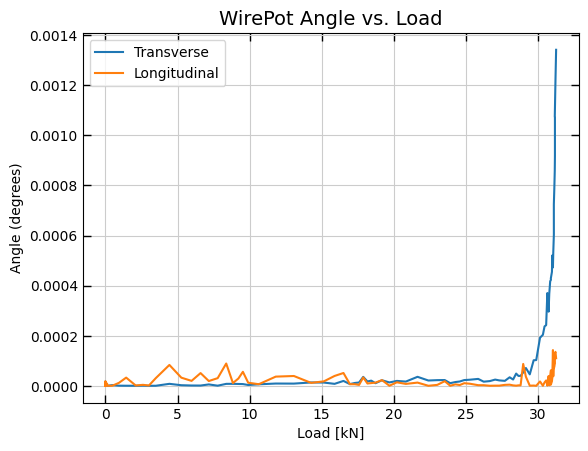

In [225]:
T1WPData = dataDFs
dT = 0.25
dL = 0.10
angleTs = []
angleLs = []
for i in range(0,len(T1WPData[0])):
  wp1 = np.array([0,0,T1WPData[0].iloc[i,1]])
  wp2 = np.array([0,dT,T1WPData[1].iloc[i,1]])
  wp3 = np.array([dL,dT,T1WPData[2].iloc[i,1]])
  wp4 = np.array([dL,0,T1WPData[3].iloc[i,1]])
  a1,b1,c1 = np.cross(wp3-wp1,wp2-wp1)
  a2,b2,c2 = np.cross(wp4-wp1,wp3-wp1)
  a3,b3,c3 = np.cross(wp4-wp2,wp3-wp2)
  a4,b4,c4 = np.cross(wp4-wp1,wp2-wp1)
  normal = np.array([np.mean([a1,a2,a3,a4]),np.mean([b1,b2,b3,b4]),np.mean([c1,c2,c3,c4])])
  normalT = normal*np.array([0,1,1])
  normalL = normal*np.array([1,0,1])
  angleT= (180/np.pi)*np.cos(np.dot(normalT,np.array([0,0,1]))/np.linalg.norm(normalT))
  angleL= (180/np.pi)*np.cos(np.dot(normalL,np.array([0,0,1]))/np.linalg.norm(normalL))
  angleTs.append(angleT)
  angleLs.append(angleL)

angleTs = angleTs - angleTs[0]
angleLs = angleLs - angleLs[0]
fig = plt.figure()
ax = fig.gca()
plt.plot(T1WPData[0].iloc[:,0],angleTs)
plt.plot(T1WPData[0].iloc[:,0],angleLs)
plt.xlabel("Load [kN]")
plt.ylabel("Angle (degrees)")
ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
ax.set_title('WirePot Angle vs. Load', fontsize = 14)
plt.legend(["Transverse","Longitudinal"])
plt.show()

# (4) Behavior of individual members

Finally, let's explore the most interesting data, the distributed strain data collected from the fiber optics sensors. The model bridge memberes are divided into 4 planes: Bottom, Left-diagonal, Right-diagonal, and Middle plane. See Figure 7.


<center>
<img src="https://github.com/UCB-CE170a/Fall2020/raw/master/homeworks/hw5/figures/figure1.png" alt="Node numbering" width="800" />
    
    Figure 7. Node numbering for the model bridge
</center>

As discussed earlier, the raw data collected by the fiber optics sensors are spatially distributed. Specifically, the data contains spatial strain information at each sample time for each fiber. The general preprocessing process is listed as the following:
* Cleaning: Convert data format, remove headers, convert units, remove meaningless items...
* Time synchronization: all the collected data is time-stamped. Unfortunately, the timing systems for different measurement equipment might be slightly different. For instance, the clock in the fiber optics analyzer is 2 minutes and 19 seconds faster than the one measuring the loading process. Synchronizing times across all equipment make the comparison/plotting of different measurements possible.
* Resampling: sometimes, the sampling rates across different equipment are different. To compare different measurements from different machines (i.e., load vs. strain), one needs to resample the collected data to match the time stamp.
* Normalization: some fibers are pre tensioned, meaning the starting measurement may not be 0. Doing normalization for the data makes the measurement (strain) comparable across different bridges.

<font color='red'>Note: the data you see in this section is far from perfect (the fibers are attached by you!). If some data does not make any sense to you, think about the potential causes for that. Try your best to discuss your findings.  </font>

For this section of the assignment, we'll focus on a few members from the <b><i>second bridge (double-angle). </b></i>

We first reread the load data, which has now been synchronized with the fiber optic data in time:

The first row of the data provides the spatial location for each strain measurement points alone the fiber. The rest of the rows are the strain measurements across the fiber (0.065 m resolution) for every sample time. To access the strain measurement for certain truss members, one need to know the corresponding spatial locations of the member on the fiber. Luckily, our kind GSI did indexing (truss member end points to fiber locations) for all the truss members for all three bridges, so we know how to access the member from the data.

## Time (load) Data Analysis
Since different groups wired fiber cables in different ways and analyzing both spatial and temporal data requires skills beyond the boundary of this class, simplified strain data is used in the later part of the assignment. Certain truss members are extracted from the data for all bridges, and only the average (spatial averaged) strain for each truss member is provided along with the corresponding load levels.

## (4.1) Diagonal Members

In [164]:
# Load appropriate information
test_widget.value = ('Test1',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('CD_I.csv', 'BC_I.csv', 'JK_I.csv', 'HJ_I.csv')
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0,), options=('Test1', 'Test2', 'Test3'), valu…

In [162]:
# Load appropriate information
test_widget.value = ('Test2',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('CD_I.csv', 'BC_I.csv', 'JK_I.csv', 'HJ_I.csv')
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(1,), options=('Test1', 'Test2', 'Test3'), valu…

In [163]:
data_widget.value

('CD_I.csv', 'BC_I.csv', 'JK_I.csv', 'HJ_I.csv')

In [166]:
# Load appropriate information
test_widget.value = ('Test3',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('CD_I.csv', 'BC_I.csv', 'JK_I.csv', 'HJ_I.csv')
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

<font color='red'>Question: </font> Describe any similarities and differences between the members. What is the strain at approximately 10 kN? Does it match your predictions? Explain your reasoning.

<font color='red'>Answer: </font>

## (4.2) Bottom Members

In [167]:
# Load appropriate information
test_widget.value = ('Test1',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('AF_I.csv', 'EF_I.csv', 'GM_I.csv', 'LM_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0,), options=('Test1', 'Test2', 'Test3'), valu…

In [168]:
# Load appropriate information
test_widget.value = ('Test2',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('AF_I.csv', 'EF_I.csv', 'GM_I.csv', 'LM_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(1,), options=('Test1', 'Test2', 'Test3'), valu…

In [169]:
# Load appropriate information
test_widget.value = ('Test3',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('AF_I.csv', 'EF_I.csv', 'GM_I.csv', 'LM_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

<font color='red'>Question: </font> Describe any similarities and differences between the members. What is the strain at approximately 10 kN? Does it match your predictions? Explain your reasoning.

<font color='red'>Answer: </font>

## (4.3) Middle Section Diagonal Members

In [170]:
# Load appropriate information
test_widget.value = ('Test1',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('HM_I.csv', 'KM_I.csv', 'BF_I.csv', 'DF_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(0,), options=('Test1', 'Test2', 'Test3'), valu…

In [171]:
# Load appropriate information
test_widget.value = ('Test2',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('HM_I.csv', 'KM_I.csv', 'BF_I.csv', 'DF_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(1,), options=('Test1', 'Test2', 'Test3'), valu…

In [172]:
# Load appropriate information
test_widget.value = ('Test3',)
sensor_widget.value = 'FiberOpticData'
data_widget.value = ('HM_I.csv', 'KM_I.csv', 'BF_I.csv', 'DF_I.csv',)
xValue.value = "Load [kN]"
plot.value = True
peak.value = True

# Call new manual interact
testInteract = interact_manual(plottingData,
                               test=test_widget,
                               sensor=sensor_widget,
                               data=data_widget,
                               xAxisData = xValue,
                               plotData = plot,
                               peakEnd=peak)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

<font color='red'>Question: </font> Describe any similarities and differences between the members. Is this plot as you would expect? Explain your reasoning.

<font color='red'>Answer: </font>

# Discussion

<font color='red'><b>Question (1): </b></font> Use the strain-load plots for the diagonal members (AG, BI, DH, JC) from problem (4.1) to revise the stiffness of the material in your FE model. Are your estimations the same across the four different members? How do they compare to the theoretical value?

* Hint1: "Load" from data is the system (total) load. Go back to Quiz 2 to find the equation to convert total load to the load felt by each member. Again, pay attention to number of angle bars for each member.

* Hint2: Reading the values from the graph is acceptable.

<font color='red'>Answer: </font>

<font color='red'><b>Question (2):</b> </font> Think back to what you observed during the tests. (Watch the videos <a href="https://drive.google.com/drive/folders/1HdlADyA2HnBFveScQDFVCDR5zo17PDfv?usp=sharing">here</a> if it helps.) Describe the deformation mechanisms of the bridges as a whole at different loading stages.

<font color='red'>Answer: </font>

<font color='red'><b>Question (3):</b></font> Discuss the validity of the assumptions that we made in the analysis given in Quiz 2.


<font color='red'>Answer: </font>

<font color='red'><b>Question (4):</b></font> If you could improve the simulation analysis, what would you do?


<font color='red'>Answer: </font>

<font color='red'><b>Question (5):</b></font> If you were allowed to add more sensors to the model bridge, what and where would you add?

<font color='red'>Answer: </font>